### 加载训练数据

In [1]:
import numpy as np
train_dict = np.load('data_dic_100.npy', allow_pickle=True).item()
print(train_dict.keys())

dict_keys(['train_losses', 'train_IoU', 'val_losses', 'val_IoU'])


### 训练数据可视化

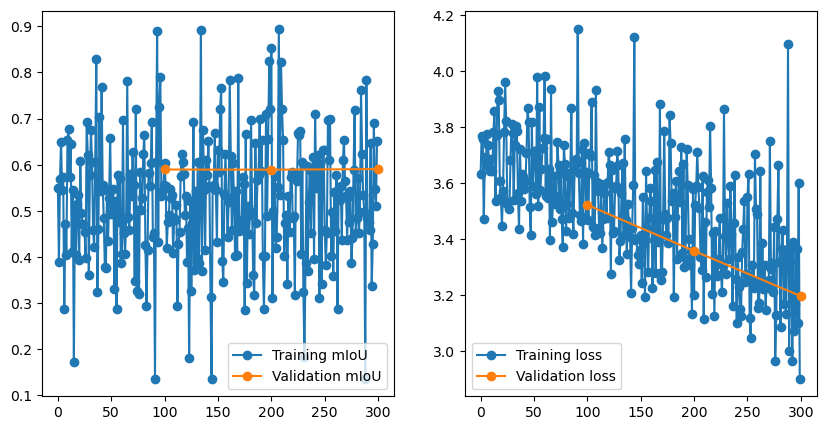

In [3]:
def plot_data(train_accs, val_accs, train_losses, val_losses, step_size):
    import matplotlib.pyplot as plt
    train_idx = np.arange(0, len(train_accs))
    val_idx = np.arange(0, len(train_accs), step_size) + step_size
    train_accs_step = train_accs
    val_accs_step = val_accs
    # x = [str(i) for i in range(len(train_accs_step))]

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))

    ax1.plot(train_idx, train_accs_step,'-o',label='Training mIoU')
    ax1.plot(val_idx, val_accs_step,'-o',label='Validation mIoU')
    ax1.legend(loc='best')

    train_losses_step = train_losses
    val_losses_step = val_losses
    x = [str(i) for i in range(len(train_losses_step))]
    ax2.plot(train_idx, train_losses_step,'-o',label='Training loss')
    ax2.plot(val_idx, val_losses_step,'-o',label='Validation loss')
    ax2.legend(loc='best')
    plt.show()

train_losses = train_dict['train_losses']
train_IoU = train_dict['train_IoU']
val_losses = train_dict['val_losses']
val_IoU = train_dict['val_IoU']

plot_data(train_IoU, val_IoU, train_losses, val_losses, 100)

### 与原始数据在测试集进行性能比较

In [3]:
from dataset_tools import ADE20KDataset
from dataset_tools import TensorDataset

device = 'cuda:0'

test_tensor_path = '/root/Desktop/我的网盘/inference_tensor_test/'
test_img_path = '/root/Desktop/我的网盘/test_set/img_test/'
test_label_path = '/root/Desktop/我的网盘/test_set/label/'

test_tensor_dataset = TensorDataset(test_tensor_path, test_label_path, device)
test_img_dataset = ADE20KDataset(test_img_path, test_label_path)

In [4]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

pspnet_config_file = '../configs/pspnet/pspnet_r50-d8_512x512_80k_ade20k.py'
pspnet_checkpoint_file = '../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth'

deeplabv3plus_config_file = '../configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py'
deeplabv3plus_checkpoint_file = '../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'

fcn_config_file = '../configs/fcn/fcn_r50-d8_512x512_80k_ade20k.py'
fcn_checkpoint_file = '../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth'

# build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

pspnet_model = init_segmentor(pspnet_config_file, pspnet_checkpoint_file, device='cuda:0')

deeplabv3plus_model = init_segmentor(deeplabv3plus_config_file, deeplabv3plus_checkpoint_file, device='cuda:0')

fcn_model = init_segmentor(fcn_config_file, fcn_checkpoint_file, device='cuda:0')

/root/Desktop/mmsegmentation-master/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth
load checkpoint from local path: ../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth
load checkpoint from local path: ../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth


In [1]:
import torch
torch.cuda.empty_cache()

### 基础模型结果推理

In [5]:
import numpy as np
from mmseg.core.evaluation import metrics
from tools import majorVote
import torch

def get_base_IoU(idx):
    img_path = test_img_dataset.get_img_path(idx)
    label = test_img_dataset.get_label_as_PIL(idx)
    label = np.array(label, dtype = np.uint8)

    pspnet_result = inference_segmentor(pspnet_model, img_path)
    fcn_result = inference_segmentor(fcn_model, img_path)
    deeplabv3p_result = inference_segmentor(deeplabv3plus_model, img_path)
    # show_result_pyplot(pspnet_model, img_path, result, get_palette('ade20k'))

    pspnet_result = np.array(pspnet_result[0], dtype = np.uint8) + 1
    fcn_result = np.array(fcn_result[0], dtype = np.uint8) + 1
    deeplabv3p_result = np.array(deeplabv3p_result[0], dtype = np.uint8) + 1

    # Major vote
    fuse_res = majorVote(pspnet_result, fcn_result, deeplabv3p_result)

    pspnet_IoU_result = np.nanmean(metrics.mean_iou([label], [pspnet_result], 150, 0)['IoU'])
    vote_IoU_result = np.nanmean(metrics.mean_iou([label], [fuse_res], 150, 0)['IoU'])
    fcn_IoU_result = np.nanmean(metrics.mean_iou([label], [fcn_result], 150, 0)['IoU'])
    deeplabv3p_IoU_result = np.nanmean(metrics.mean_iou([label], [deeplabv3p_result], 150, -1)['IoU'])

    del pspnet_result, fcn_result, deeplabv3p_result, fuse_res, label
    torch.cuda.empty_cache()
    
    return pspnet_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result

pspnet_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result = get_base_IoU(1)

print("pspnet_IoU_result: ", pspnet_IoU_result)
print("fcn_IoU_result: ", fcn_IoU_result)
print("deeplabv3p_IoU_result: ", deeplabv3p_IoU_result)
print("vote_IoU_result: ", vote_IoU_result)


pspnet_IoU_result:  0.3649640632105461
fcn_IoU_result:  0.48423106778333597
deeplabv3p_IoU_result:  0.3740188160369628
vote_IoU_result:  0.40056844462545166


In [17]:
import torch
from Ensemble_model import FusionModel
from mmseg.core.evaluation import metrics

def get_model_IoU(idx, model, device):
    # FusionModel inference
    tensor_dict, annotation_tensor = test_tensor_dataset[idx]
    annotation_tensor -= 1 # 忽略背景类，将label范围从1-150变为0-149
    
    deeplabv3p_logits_res = tensor_dict['deeplabv3p'].to(device)
    pspnet_logits_res = tensor_dict['pspnet'].to(device)
    fcn_logits_res = tensor_dict['fcn'].to(device)

    res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res) # (150, H, W)
    res = res.argmax(0)
    
    # calculate IoU
    fusion_IoU_result = np.nanmean(metrics.mean_iou(annotation_tensor.cpu().numpy(), res.cpu().numpy(), 150, -1)['IoU'])

    del tensor_dict, annotation_tensor, deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res, res
    torch.cuda.empty_cache()
    return fusion_IoU_result

model = torch.load('/root/Desktop/我的网盘/fusion_model.pth')   
model = model.to('cuda:1')
fusion_IoU_result = get_model_IoU(0, model, 'cuda:1')
print("fusion_IoU_result: ", fusion_IoU_result)

fusion_IoU_result:  0.6724361656505448


### 画出Test set上表现最好的方法

100%|██████████| 10/10 [01:56<00:00, 11.68s/it]


<BarContainer object of 4 artists>

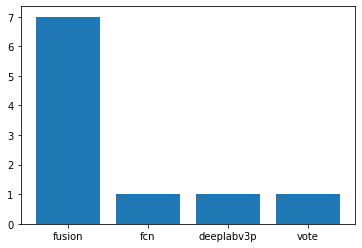

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

test_IoU = []
for i in tqdm(range(len(test_img_dataset))):
    pspnet_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result = get_base_IoU(i)
    fusion_IoU_result = get_model_IoU(i, model, 'cuda:1')
    iter_IoU = [pspnet_IoU_result, fusion_IoU_result, vote_IoU_result, fcn_IoU_result, deeplabv3p_IoU_result]
    test_IoU.append(iter_IoU)

test_IoU_array = np.array(test_IoU)
np.save('/root/Desktop/我的网盘/test_IoU_50.npy',test_IoU_array)

best_method = []
method_dic = {0:'pspnet', 1:'fusion', 2:'vote', 3:'fcn', 4:'deeplabv3p'}
for res in test_IoU:
    best_method.append(method_dic[np.argmax(res)])

performance = Counter(best_method)
plt.bar(performance.keys(), performance.values())


### 加载本地测试集IoU数据

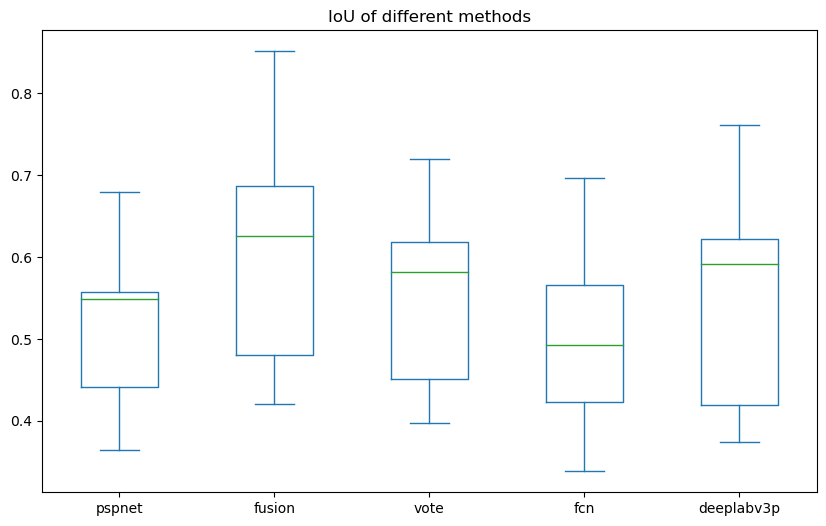

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

test_IoU = np.load('test_IoU_50.npy')
test_IoU = test_IoU.tolist()

df = pd.DataFrame(test_IoU, columns=['pspnet', 'fusion', 'vote', 'fcn', 'deeplabv3p'])

df.plot(kind='box', figsize=(10, 6), title='IoU of different methods')

plt.show()

### FusionModel 权重可视化

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class FusionModel(nn.Module):
    '''
    输入: 三个模型的分割结果
    输出: 融合后的分割结果
    说明:
        每一个分割结果对应一个长度为150的向量, 每个向量的第i个元素表示第i类的权重
        三个分割结果的权重向量相加, 然后softmax, 得到最终的分割结果
    '''
    def __init__(self, class_num):
        super().__init__()
        # class_num: 150
        self.w1 = torch.nn.Parameter(torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1)) 
        self.w2 = torch.nn.Parameter(torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1))
        self.w3 = torch.nn.Parameter(torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1))
        self.Softmax = nn.Softmax()
        
    def forward(self, input_seg1, input_seg2, input_seg3):
        # input_seg size: (150, H, W)
        # TODO: Softmax dim BUG HERE
        # res = self.Softmax(res, dim=0) 
        return input_seg1 * self.w1 + input_seg2 * self.w2 + input_seg3 * self.w3


model = torch.load('fusion_model_100.pth', map_location=torch.device('cpu'))

In [6]:
import pandas as pd

df = pd.DataFrame()
# print(model.state_dict())
for name in model.state_dict():
    weight = model.state_dict()[name].squeeze(1).squeeze(1).numpy().reshape(1, -1).tolist()
    df = df.append(weight, ignore_index=True)
df = df.T
df = df.rename(columns={0:'deeplabv3p', 1:'pspnet', 2:'fcn'})


/var/folders/49/bqdshwxd7cn1kn88j3cflpv00000gn/T/ipykernel_19571/2710087215.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(weight, ignore_index=True)


Text(0.5, 1.0, 'weight of different methods')

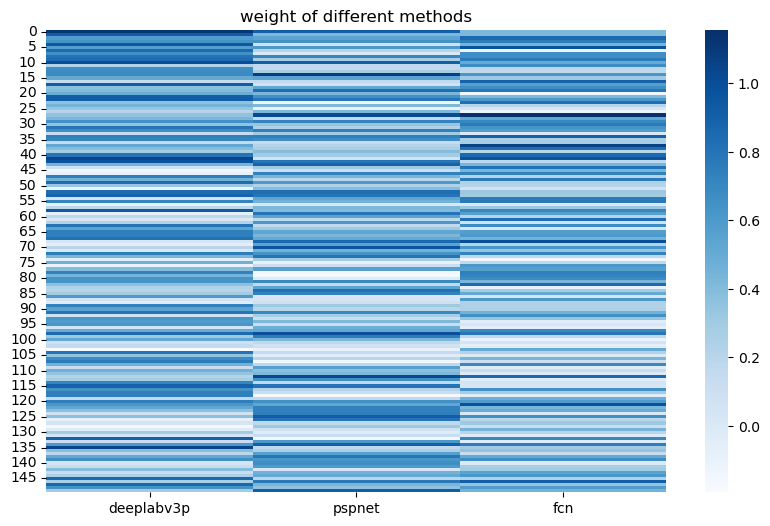

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='Blues')
plt.title('weight of different methods')

In [8]:
test_IoU_array = np.load('test_IoU_50.npy')
test_IoU_df = pd.DataFrame(test_IoU_array, columns=['pspnet', 'fusion', 'vote', 'fcn', 'deeplabv3p'])
test_IoU_df.mean()

pspnet        0.512570
fusion        0.614722
vote          0.547305
fcn           0.498177
deeplabv3p    0.542143
dtype: float64

### EnSeg分割结果可视化

In [ ]:
from mmseg.apis import show_result_pyplot
# FusionModel inference
tensor_dict, annotation_tensor = test_tensor_dataset[2]
annotation_tensor -= 1 # 忽略背景类，将label范围从1-150变为0-149
    
deeplabv3p_logits_res = tensor_dict['deeplabv3p'].to(device)
pspnet_logits_res = tensor_dict['pspnet'].to(device)
fcn_logits_res = tensor_dict['fcn'].to(device)

res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res) # (150, H, W)
res_pred = res.argmax(0) + 1



